In [1]:
import xesmf as xe
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
from matplotlib.colors import LogNorm
import xroms
import numpy as np
import seawater as sw
from dask.diagnostics import ProgressBar
import scipy.integrate as integ


import sys
sys.path.append("/homes/metogra/iufarias/Documents/Scripts/useful")
import romspickle as rp

from dask.diagnostics import ProgressBar
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [2]:
!which conda

/homes/metogra/iufarias/miniconda3/bin/conda


In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
# client=dask.distributed.Client()
# client

In [5]:

def calc_MLD(dens_int,fillna=2e20,thresh=0.125,coo='z_rho'):
    '''
    dens_int: Interpolated density xarray (from xroms.isoslice)
    '''
    if coo in dens_int.dims:            
        dens_int_new=dens_int.dropna(coo)
        zdic={'{0}'.format(coo):0}
        mld_dens = dens_int_new.isel(zdic) - thresh
        
        z_indexes = (abs(dens_int_new - mld_dens)).fillna(fillna).argmin(coo)
        mld_f = dens_int_new[coo][z_indexes]
    else:
        print('z_rho dimension not found')
    
    return mld_f

In [6]:
chunks={'time_counter':10, 'x_rho':1000, 'y_rho':1520,'s_rho':40,'s_w':40}

#3D
path='/data/pacific/lrenault/SASI/CROCO/'

varf=xr.open_mfdataset(path + 'FULL/SASI*.nc',data_vars='minimal', chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*.nc',data_vars='minimal', chunks=chunks)



In [7]:
# zf=rp.zlevs(h=varf.h.to_numpy(),zeta=varf.zeta[0].to_numpy(),
#          theta_s=np.int(varf.theta_s),theta_b=np.int(varf.theta_b),
#          hc=np.int(varf.hc),N=80)

# zt=rp.zlevs(h=varf.h.to_numpy(),zeta=varf.zeta[0].to_numpy(),
#          theta_s=np.int(varf.theta_s),theta_b=np.int(varf.theta_b),
#          hc=np.int(varf.hc),N=80) 

In [8]:
# varf=varf.assign_coords(z_rho=(('s_rho','y_rho','x_rho'),zf))
# vart=vart.assign_coords(z_rho=(('s_rho','y_rho','x_rho'),zt))

In [9]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=2)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=2)

### KE Spectra Calculation

In [9]:
dec=50
c_dec=int(df.u.shape[0]/dec)

In [10]:
# chunks_vel={'ocean_time':1,'s_rho':1}
chunks_vel={'ocean_time':c_dec,'s_rho':1}

In [115]:
with ProgressBar():
    uf=df.u.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];uf=uf.chunk(chunks=chunks_vel).compute()
    vf=df.v.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];vf=vf.chunk(chunks=chunks_vel).compute()
    
    ut=dt.u.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];ut=ut.chunk(chunks=chunks_vel).compute()
    vt=dt.v.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];vt=vt.chunk(chunks=chunks_vel).compute()

In [10]:

# import gc
# client.run(gc.collect)  # collect garbage on all workers

In [103]:
with ProgressBar():
    ufi=uf.xroms.isoslice(np.linspace(-5,-100, 10))
    vfi=vf.xroms.isoslice(np.linspace(-5,-100, 10))
    uti=ut.xroms.isoslice(np.linspace(-5,-100, 10))
    vti=vt.xroms.isoslice(np.linspace(-5,-100, 10))

In [104]:
with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(ufi.drop(['z_rho_psi']),
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    Vf=xrft.isotropic_power_spectrum(vfi.drop(['z_rho_psi']),
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    Ut=xrft.isotropic_power_spectrum(uti.drop(['z_rho_psi']),
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    Vt=xrft.isotropic_power_spectrum(vti.drop(['z_rho_psi']),
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)



In [105]:
# Ekef=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))
# Eket=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))

# KEf=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'z_rho_psi':Uf.z_rho_psi,'freq_r':Uf.freq_r.data}))
# KEt=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'z_rho_psi':Uf.z_rho_psi,'freq_r':Uf.freq_r.data}))


KEf=xr.DataArray(data=0.5*(Uf.data + Vf.data),
                 coords=({'ocean_time':Uf.ocean_time.data,'z_rho_psi':Uf.z_rho_psi.data,'freq_r':Uf.freq_r.data}))
KEt=xr.DataArray(data=0.5*(Ut.data + Vt.data),
                 coords=({'ocean_time':Ut.ocean_time.data,'z_rho_psi':Uf.z_rho_psi.data,'freq_r':Uf.freq_r.data}))

In [106]:
KEf_sum=KEf.sum('z_rho_psi')
KEt_sum=KEt.sum('z_rho_psi')

In [107]:
dxx=0.5

## Plotting Averaged Spectrum

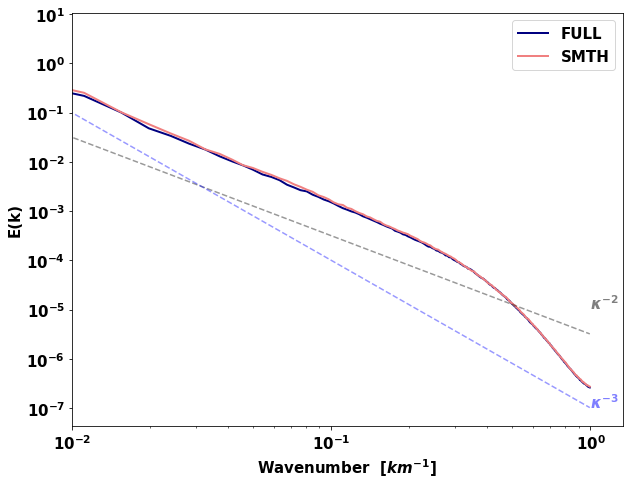

In [108]:

plt.figure(figsize=(9,7))

plt.plot(KEf_sum.freq_r/dxx,KEf_sum.mean('ocean_time'),label='FULL',linewidth=2,color='navy')
plt.plot(KEt_sum.freq_r/dxx,KEt_sum.mean('ocean_time'),label='SMTH',linewidth=2,color='lightcoral')

# plt.plot([1/50,1/50],[1000,0],'k--')


k2 = np.array([KEf_sum.freq_r[0],KEf_sum.freq_r[-1]])/dxx
E2 = (1/k2)**2/(10**5.5)

k3 = np.array([KEf_sum.freq_r[0],KEf_sum.freq_r[-1]])/dxx
E3 = (1/k3)**3/(10**7)

# k53 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
# E53 = (1/k53)**(5/3)/(10**5)

plt.plot(k2,E2,'k--',alpha=0.4)
plt.text(1,1e-5,r'$\kappa^{-2}$',weight='normal',alpha=0.5)

plt.plot(k3,E3,'b--',alpha=0.4)
plt.text(1,1e-7,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.5)



plt.legend()

plt.yscale('symlog',linthreshy=1e-11)
plt.xscale('log')



# plt.title('EKE')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'E(k)',fontweight='bold')

plt.xlim(1/100,0)
# plt.ylim(-1e-11,1e-8)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/z_integ_Total_avg_KE.png')

## Ogive graphs

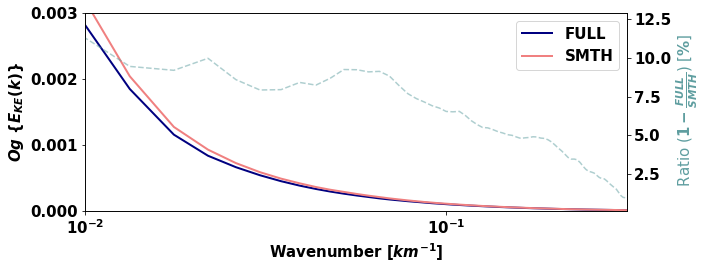

In [109]:
'Ogive graph - Backwards'


Kf=KEf_sum.mean('ocean_time')
Kt=KEt_sum.mean('ocean_time')

# Kf=KEf_sum
# Kt=KEt_sum

Kk=np.array(KEf_sum.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


KAf=integ.cumtrapz(y=Kf[::-1],x=Kk[::-1]);
KAt=integ.cumtrapz(y=Kt[::-1],x=Kk[::-1]);

KAf=-KAf[::-1]
KAt=-KAt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((np.log10(Kx)),KAf,label='FULL',linewidth=2,color='navy')
ax.plot((np.log10(Kx)),KAt,label='SMTH',linewidth=2,color='lightcoral')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{KE}(k)$}',color="k",fontsize=15,fontweight='bold')
ax.set_xlim(-2,-0.5)
ax.set_ylim(-1e-5,3e-3)



ax.legend()

ax2=ax.twinx()
ax2.plot(np.log10(Kx),(1-(KAf)/(KAt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/z_integ_Ogive_avg_KE.png')

## VBP

In [129]:
dec=50
c_dec=int(df.u.shape[0]/dec)

In [130]:
# chunks_rho={'ocean_time':1,'s_rho':1}
chunks_rho={'ocean_time':c_dec,'s_rho':1}

In [131]:
with ProgressBar():
    tf=df.temp.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];tf=tf.chunk(chunks=chunks_rho).compute()
    sf=df.salt.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];sf=sf.chunk(chunks=chunks_rho).compute()
    
    tt=dt.temp.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];tt=tt.chunk(chunks=chunks_rho).compute()
    st=dt.salt.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];st=st.chunk(chunks=chunks_rho).compute()

[########################################] | 100% Completed | 15min 50.4s
[########################################] | 100% Completed | 13min 44.0s
[########################################] | 100% Completed | 14min  3.9s
[########################################] | 100% Completed | 13min 42.8s


In [ ]:
with ProgressBar():
    rhof=xroms.potential_density(tf,sf)
    rhot=xroms.potential_density(tt,st)



In [135]:
with ProgressBar():
    bf=xroms.buoyancy(rhof)
    bt=xroms.buoyancy(rhot)
    

In [188]:
with ProgressBar():
    wf=df.w.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];wf=wf.chunk(chunks=chunks_rho).compute()
    wt=dt.w.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];wt=wt.chunk(chunks=chunks_rho).compute()

[########################################] | 100% Completed | 14min 25.1s
[########################################] | 100% Completed | 14min  9.7s


In [189]:
with ProgressBar():
    bfi=bf.xroms.isoslice(np.linspace(-5,-100, 10))
    wfi=wf.xroms.isoslice(np.linspace(-5,-100, 10))
    bti=bt.xroms.isoslice(np.linspace(-5,-100, 10))
    wti=wt.xroms.isoslice(np.linspace(-5,-100, 10))

In [199]:
del bfi.attrs['grid']
del wfi.attrs['grid']
del bti.attrs['grid']
del wti.attrs['grid']

In [200]:
# bfi.to_netcdf("/homes/metogra/iufarias/Documents/data/bfi.nc")
# bti.to_netcdf("/homes/metogra/iufarias/Documents/data/bti.nc")
# wfi.to_netcdf("/homes/metogra/iufarias/Documents/data/wfi.nc")
# wti.to_netcdf("/homes/metogra/iufarias/Documents/data/wti.nc")

In [21]:

bfi=xr.open_dataarray("/homes/metogra/iufarias/Documents/data/bfi.nc")
bti=xr.open_dataarray("/homes/metogra/iufarias/Documents/data/bti.nc")
wfi=xr.open_dataarray("/homes/metogra/iufarias/Documents/data/wfi.nc")
wti=xr.open_dataarray("/homes/metogra/iufarias/Documents/data/wti.nc")

In [23]:
VBP_f=xrft.isotropic_cross_spectrum(wfi.drop(['z_rho_psi']),
                                bfi.drop(['z_rho_psi']),
                                         dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True).real

VBP_t=xrft.isotropic_cross_spectrum(wti.drop(['z_rho_psi']),
                                bti.drop(['z_rho_psi']),
                                         dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True).real

In [24]:
VBP_f_sum=VBP_f.sum('z_rho_psi')
VBP_t_sum=VBP_t.sum('z_rho_psi')

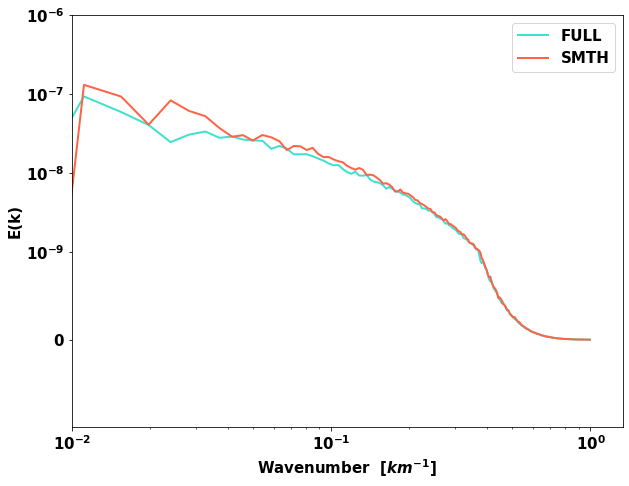

In [41]:
plt.figure(figsize=(9,7))

plt.plot(VBP_f_sum.freq_r/dxx,VBP_f_sum.mean('ocean_time'),label='FULL',linewidth=2,color='turquoise')
plt.plot(VBP_t_sum.freq_r/dxx,VBP_t_sum.mean('ocean_time'),label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()

plt.yscale('symlog',linthreshy=1e-9)
plt.xscale('log')



# plt.title('EKE')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'E(k)',fontweight='bold')

plt.xlim(1/100,0)
plt.ylim(-1e-9,1e-6)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/z_integ_Total_avg_VBP.png')

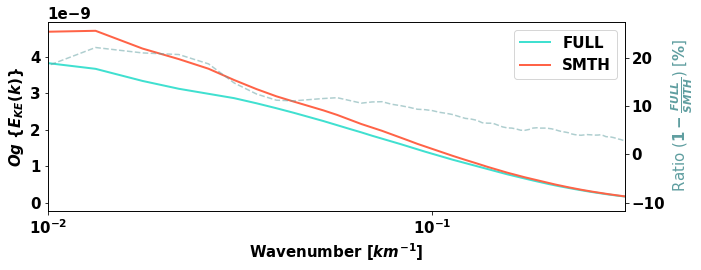

In [51]:
'Ogive graph - Backwards'


Kf=VBP_f_sum.mean('ocean_time')
Kt=VBP_t_sum.mean('ocean_time')

# Kf=KEf_sum
# Kt=KEt_sum

Kk=np.array(VBP_f_sum.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


KAf=integ.cumtrapz(y=Kf[::-1],x=Kk[::-1]);
KAt=integ.cumtrapz(y=Kt[::-1],x=Kk[::-1]);

KAf=-KAf[::-1]
KAt=-KAt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((np.log10(Kx)),KAf,label='FULL',linewidth=2,color='turquoise')
ax.plot((np.log10(Kx)),KAt,label='SMTH',linewidth=2,color='tomato')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{KE}(k)$}',color="k",fontsize=15,fontweight='bold')
ax.set_xlim(-2,-0.5)
# ax.set_ylim(-1e-5,3e-3)



ax.legend()

ax2=ax.twinx()
ax2.plot(np.log10(Kx),(1-(KAf)/(KAt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/z_integ_Ogive_avg_VBP.png')

In [19]:
%%time
tf=df.temp.groupby("ocean_time.dayofyear").mean();
tf=tf.chunk(chunks=chunks_rho)
tf=tf[:,-15:-1,300:-300,90:700]
tf=tf.chunk(chunks=chunks_rho)


sf=df.salt.groupby("ocean_time.dayofyear").mean();
sf=sf.chunk(chunks=chunks_rho)
sf=sf[:,-15:-1,300:-300,90:700]
sf=sf.chunk(chunks=chunks_rho)

CPU times: user 631 ms, sys: 5.45 ms, total: 636 ms
Wall time: 631 ms


In [8]:
%%time
with ProgressBar():
    bb=tf[0,-5:-1,:,:].compute()


[########################################] | 100% Completed | 14.7s
CPU times: user 1min 1s, sys: 47.3 s, total: 1min 48s
Wall time: 14.8 s


In [9]:
%%time

rhof=xroms.potential_density(tf,sf)
bf=xroms.buoyancy(rhof)

CPU times: user 742 ms, sys: 2.75 ms, total: 745 ms
Wall time: 746 ms


In [7]:
# %%time

# tt=dt.temp.groupby("ocean_time.dayofyear").mean();
# # tt=dt.temp.groupby("ocean_time.month").mean();
# tt=tt.isel(s_rho=range(-15,-1),xi_rho=range(800));
# tt=tt.isel(eta_rho=range(100,1300));
# tt=tt.chunk(chunks=chunks_rho)


# st=dt.salt.groupby("ocean_time.dayofyear").mean();
# # st=dt.salt.groupby("ocean_time.month").mean();
# st=st.isel(s_rho=range(-15,-1),xi_rho=range(800));
# st=st.isel(eta_rho=range(100,1300));
# st=st.chunk(chunks=chunks_rho)





In [10]:
%%time

tt=dt.temp.groupby("ocean_time.dayofyear").mean();
tt=tf.chunk(chunks=chunks_rho)
tt=tt[:,-15:-1,300:-300,90:700]
tt=tt.chunk(chunks=chunks_rho)


st=dt.salt.groupby("ocean_time.dayofyear").mean();
st=sf.chunk(chunks=chunks_rho)
st=st[:,-15:-1,300:-300,90:700]
st=st.chunk(chunks=chunks_rho)


CPU times: user 1.25 s, sys: 7.52 ms, total: 1.25 s
Wall time: 1.25 s


In [11]:
%%time
rhot=xroms.potential_density(tt,st)
bt=xroms.buoyancy(rhot)

CPU times: user 756 ms, sys: 68 µs, total: 756 ms
Wall time: 755 ms


In [12]:
%%time 
wf=df.w.groupby("ocean_time.dayofyear").mean();
# wf=df.w.groupby("ocean_time.month").mean();
# wf=wf.isel(s_rho=range(-15,-1),xi_rho=range(800));
# wf=wf.isel(eta_rho=range(100,1300));
# wf=wf.chunk(chunks=chunks_rho)

wf=wf[:,-15:-1,300:-300,90:700]
wf=wf.chunk(chunks=chunks_rho)




CPU times: user 628 ms, sys: 4.58 ms, total: 632 ms
Wall time: 628 ms


In [13]:
%%time
wt=dt.w.groupby("ocean_time.dayofyear").mean();
# wt=dt.w.groupby("ocean_time.month").mean();
# wt=wt.isel(s_rho=range(-15,-1),xi_rho=range(800));
# wt=wt.isel(eta_rho=range(100,1300));
# wt=wt.chunk(chunks=chunks_rho)

wt=wt[:,-15:-1,300:-300,90:700]
wt=wt.chunk(chunks=chunks_rho)



CPU times: user 703 ms, sys: 5.06 ms, total: 709 ms
Wall time: 704 ms


In [14]:
Bfi=bf.sum(axis=1)
Bti=bt.sum(axis=1)
Wfi=wf.sum(axis=1)
Wti=wt.sum(axis=1)

In [48]:
%%time
with ProgressBar():
    VBPf=xrft.isotropic_cross_spectrum(Wfi[:,:,:].drop(['nav_lat_rho', 'nav_lon_rho']).compute(),
                                       Bfi[:,:,:].drop(['nav_lat_rho', 'nav_lon_rho']).compute(),dim=['xi_rho','eta_rho'],nfactor=2,truncate='True',detrend='linear', window=True)

[########################################] | 100% Completed | 30min 58.0s
[########################################] | 100% Completed |  1hr  0min  8.6s
CPU times: user 45min 59s, sys: 1h 34min 36s, total: 2h 20min 35s
Wall time: 1h 31min 27s


In [50]:
VBPf.real.to_netcdf("/homes/metogra/iufarias/Documents/data/VBPf.nc")

In [19]:
%%time
with ProgressBar():
    VBPt=xrft.isotropic_cross_spectrum(dd.drop(['nav_lat_rho', 'nav_lon_rho']),
                                       cc.drop(['nav_lat_rho', 'nav_lon_rho']),dim=['xi_rho','eta_rho'],nfactor=2,truncate='True',detrend='linear', window=True)

CPU times: user 3min 8s, sys: 8min 30s, total: 11min 39s
Wall time: 14.2 s


In [20]:
VBPt.real.to_netcdf("/homes/metogra/iufarias/Documents/data/VBPt.nc")

In [12]:
VBPt=xr.DataArray("/homes/metogra/iufarias/Documents/data/VBPt.nc")
VBPf=xr.DataArray("/homes/metogra/iufarias/Documents/data/VBPf.nc")

In [22]:
from netCDF4 import Dataset
VBPf=Dataset("/homes/metogra/iufarias/Documents/data/VBPf.nc")
VBPt=Dataset("/homes/metogra/iufarias/Documents/data/VBPt.nc")

In [24]:
VBPt['__xarray_dataarray_variable__'][:].shape

(214, 2)

## Mixed Layer Depth

##### Loading in Temperature and Salinity

In [10]:
with ProgressBar():
    # tf=df.temp[400,:,300:-300,90:700].compute()
    # sf=df.salt[400,:,300:-300,90:700].compute()
    
    tf=df.temp[::2*15,-20:,300:-300,90:700].mean(axis=0).compute()
    sf=df.salt[::2*15,-20:,300:-300,90:700].mean(axis=0).compute()

[########################################] | 100% Completed | 15.0s
[########################################] | 100% Completed | 14.5s


In [11]:
with ProgressBar():
    # tt=dt.temp[400,:,300:-300,90:700].compute()
    # st=dt.salt[400,:,300:-300,90:700].compute()
    
    tt=dt.temp[::2*15,-20:,300:-300,90:700].mean(axis=0).compute()
    st=dt.salt[::2*15,-20:,300:-300,90:700].mean(axis=0).compute()

[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.6s


##### Computing Potential Density

In [12]:
with ProgressBar():
    # sig0=xroms.potential_density(tf,sf)
    rhof=xroms.potential_density(tf,sf)
    rhot=xroms.potential_density(tt,st)


##### Interpolating in Z for calculating MLD

In [13]:
sig_f_int=xroms.isoslice(rhof, np.linspace(0,-200, 90),iso_array=rhof.z_rho0)
sig_t_int=xroms.isoslice(rhot, np.linspace(0,-200, 90),iso_array=rhot.z_rho0)

In [14]:

mld_int_f=calc_MLD(sig_f_int,thresh=-0.125,coo='z_rho0')
mld_int_t=calc_MLD(sig_t_int,thresh=-0.125,coo='z_rho0')

##### Plotting MLD (density)

In [44]:
# mlddiff[460,305]
# mld_int_f[460,305]
# mld_int_t[460,305]
# mldmean[460,305]

# (mlddiff/mldmean)[460,305]*100

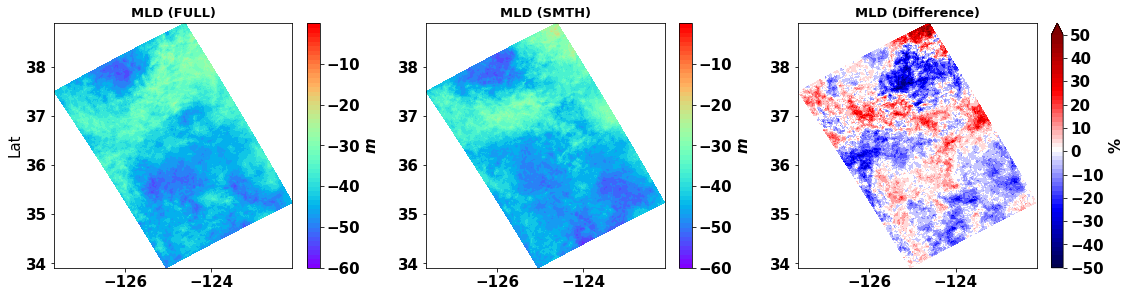

In [36]:
plt.figure(figsize=(16,8))

lvls=np.arange(-60,0,10)

plt.subplot(2,3,1)
mld_int_f.plot(x='nav_lon_rho',y='nav_lat_rho',
                             cmap='rainbow',levels=np.linspace(-60,0,55),
                             cbar_kwargs={'ticks': lvls,'label':'$m$ '})

plt.title(r'MLD (FULL)',fontsize=13,fontweight='bold')
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,3,2)

mld_int_t.plot(x='nav_lon_rho',y='nav_lat_rho',
                             cmap='rainbow',levels=np.linspace(-60,0,55),
                             cbar_kwargs={'ticks': lvls,'label':'$m$ '})
plt.title(r'MLD (SMTH)',fontsize=13,fontweight='bold')

plt.xlabel('')
plt.ylabel('')


plt.subplot(2,3,3)

mlddiff=mld_int_f-mld_int_t
mldmean=0.5*(mld_int_f + mld_int_t)



((mlddiff/mldmean)*100).plot(x='nav_lon_rho',y='nav_lat_rho',
                             cmap='seismic',levels=np.linspace(-50,50,55),
          cbar_kwargs={'ticks':np.arange(-50,60,10),'label':r'$\%$'})
plt.title(r'MLD (Difference)',fontsize=13,fontweight='bold')

plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/MLD_diffs.png')

##### Plotting MLD (Temperature)

In [202]:

# T_int=xroms.isoslice(tf,iso_values=np.linspace(0,-300, 90),axis='Z')
# mld2=calc_MLD(T_int,thresh=+0.5)

# plt.figure(figsize=(10,8))
# plt.contourf(mld2,levels=np.linspace(-100,-3,55),cmap='rainbow',extend='both')

# plt.colorbar()

#### How to interpolate profile

In [19]:
tint=xroms.isoslice(tf, np.linspace(0, -3000, 50))